In [1]:
import networkx as nx
import numpy as np
import pandas as pd 

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
G = nx.DiGraph()

G.add_edge('cron', '1.py')
G.add_edge('cron', '2.py')
G.add_edge('cron', '3.py')
G.add_edge('cron', '4.py')
G.add_edge('cron', '5.py')
G.add_edge('cron', '6.py')

# 1.py
G.add_edge('1.py', '1_output.json')

# 2.py
G.add_edge('2.py', '2_output.json')

# 3.py
G.add_edge('1_output.json', '3.py') # input, script on right file/db on left
G.add_edge('2_output.json', '3.py')
G.add_edge('3.py', 'mysql') # output, script on left

# 4.py
G.add_edge('1_output.json', '4.py')
G.add_edge('2_output.json', '4.py')
G.add_edge('4.py', 'mysql')

# 5.py
G.add_edge('mysql', '5.py')
G.add_edge('5.py', 'extract_thing_1.json')
G.add_edge('5.py', 'extract_thing_2.json')

# 6.py
G.add_edge('extract_thing_1.json', '6.py')
G.add_edge('extract_thing_2.json', '6.py')
G.add_edge('6.py', 'combined_export.json')

In [5]:
print(G)

DiGraph with 13 nodes and 20 edges


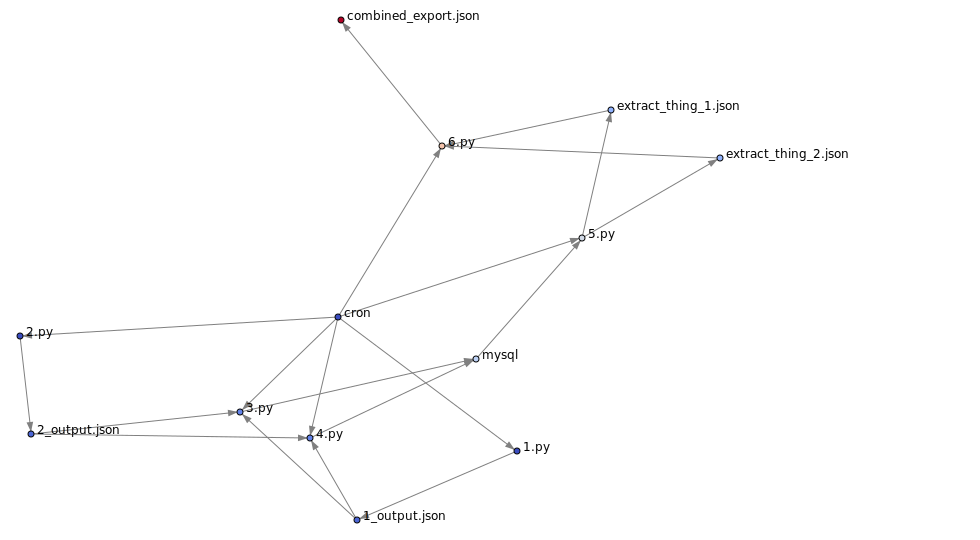

In [6]:
# imaginary software that uses cron for orchestration and creates one combined export

draw_graph(G, node_size=3, show_names=True, edge_width=1, font_size=12)

# Drop Cron to see Different View

When I map out software, I like to start at the ORCHESTRATION, as that is the ground truth of what is automated and when it runs. From there, I can find additional dependencies (nested script calls, files used, databases used, and more). I sometimes visualize the graph with 'cron' or the orchestration as part of the network, but sometimes I like to see things without. You can remove the orchestration node for another view, once the network is built. I do recommend starting at the orchestration, though, and that is often cron, in my experience.

In [7]:
G.remove_node('cron')

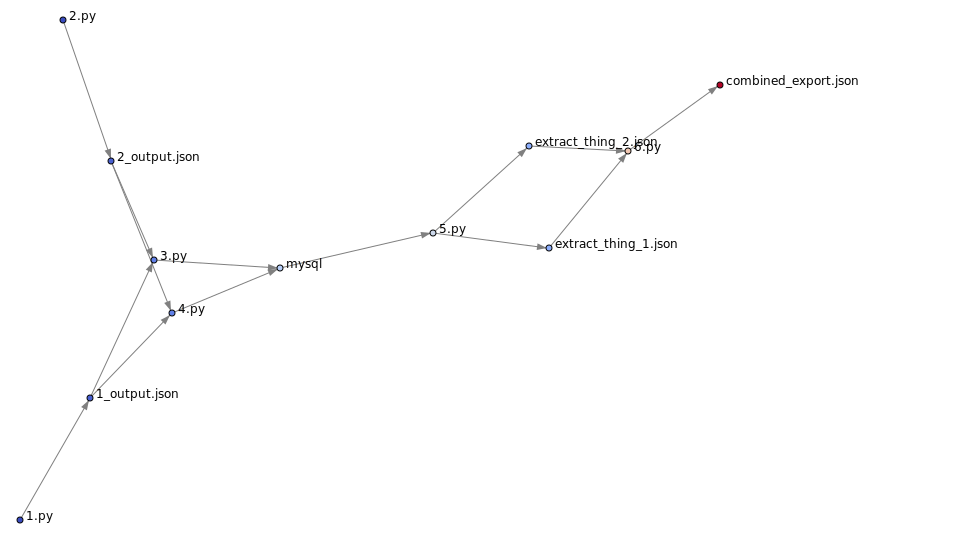

In [8]:
draw_graph(G, node_size=3, show_names=True, edge_width=1, font_size=12)

# Network Science Goodies are Useful

From here, all of the stuff that I have previously written about can be useful. This is just another network that can be analyzed and explored.

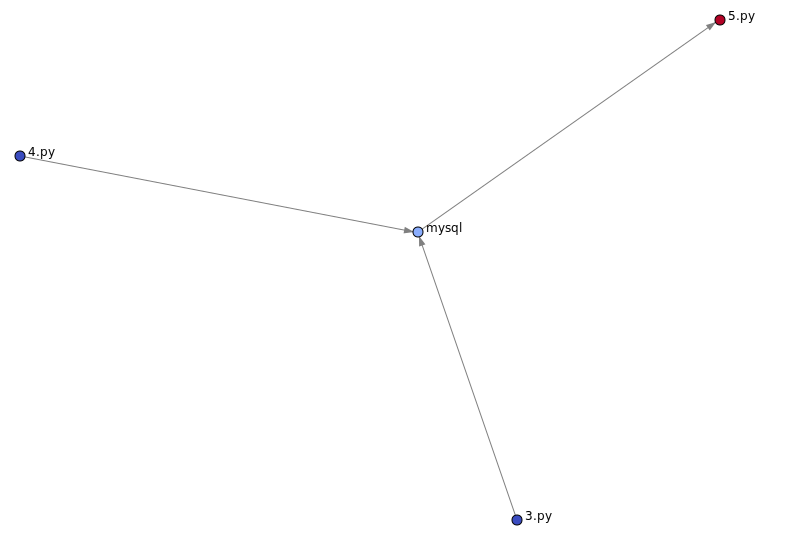

In [9]:
subgraph_nodes = ['3.py', '4.py', 'mysql', '5.py']

G_sub = G.subgraph(subgraph_nodes)

draw_graph(G_sub, node_size=5, show_names=True, edge_width=1, font_size=12)

# Critical Nodes

Actually, all nodes are critical, but these nodes are situated in a way that if they stop, they will disrupt the most things.

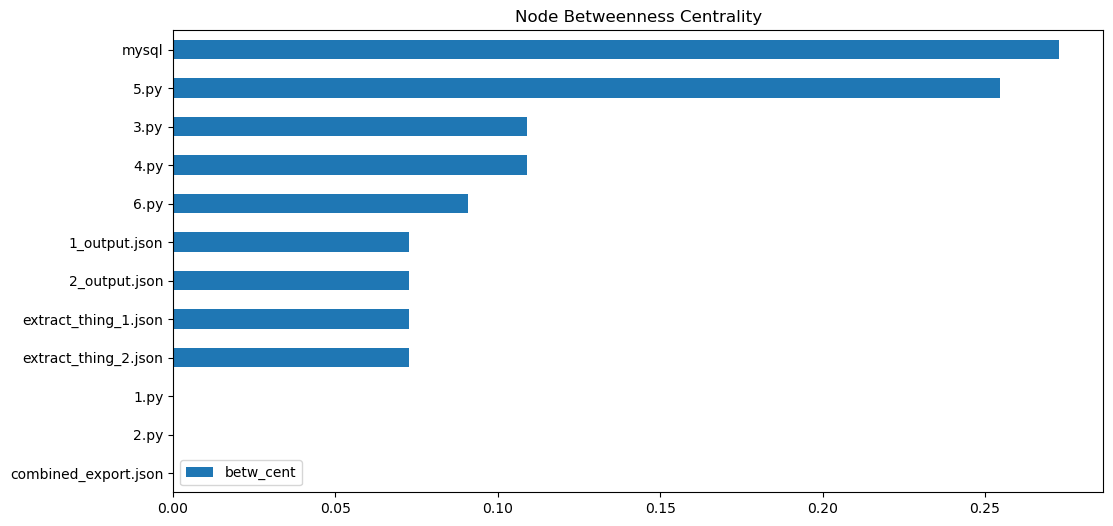

In [10]:
betw_cent = nx.betweenness_centrality(G)

metric_df = pd.DataFrame(betw_cent, index=[0]).T
metric_df.columns = ['betw_cent']
metric_df.sort_values('betw_cent', ascending=False, inplace=True)

metric_df.head(20).plot.barh(title='Node Betweenness Centrality', figsize=(12,6)).invert_yaxis()

# Look at Inputs

Basically, what goes into something? What leads to something? In this case, what leads to data being in MySQL?

In [11]:
nx.ancestors(G, 'mysql')

{'1.py', '1_output.json', '2.py', '2_output.json', '3.py', '4.py'}

# Look at Outputs

Basically, what is impacted if something stops working? What is impacted if MySQL goes down?

In [12]:
nx.descendants(G, 'mysql')

{'5.py',
 '6.py',
 'combined_export.json',
 'extract_thing_1.json',
 'extract_thing_2.json'}

# I Spent Years on This

I spent years developing techniques for Source Code Analysis (SCA) and dataflow mapping. This notebook is only scratching the surface. This is incredibly useful in data operations, if you learn more, but this is enough to get started. I will discuss this more, if there is interest, and potentially write a book on this topic someday as it has been very useful to me.

There's a lot further even I could go into this, even with how much time I spent doing this. However, to be effective, you don't really need much. You need to map out the system, and then you can easily interrogate the graph to find what's what.

But code and dataflow networks present another opportunity for analysis, and this is also extremely useful in troubleshooting, especially after you have mapped out enough systems.